In [0]:
import os
import json
import numpy as np
from random import randrange
import zipfile

## Experiment 1 - Eearnings Transcript - GLOVE


###1.Preprocess Data

In [0]:
def load_data(link):
  
  text = []
  sentiment = []

  for filename in os.listdir(link):
    if filename != '.ipynb_checkpoints':
      file_path = os.path.join(link, filename)
      with open(file_path, encoding = 'unicode_escape') as f:
        dic = json.load(f)

        for k, v in dic['text'].items():
          text.append(v)
        for k, v in dic['sentiment'].items():
          sentiment.append(v)
  return text, sentiment

In [0]:
def preprocess_data(text, sentiment):
  # 80-20 split
  combo = [list(i) for i in zip(text, sentiment)]
  
  combo_test = []

  test_size = int(len(combo)*0.2)
  while len(combo_test) < test_size:
    index = randrange(len(combo))
    combo_test.append(combo.pop(index))
  
  x_train = []
  y_train = []
  x_test = []
  y_test = []
  # x, y split
  for line in combo:
    x_train.append(line[0])
    if line[1] in ['Positive', 'positive', 'postive']:
      y_train.append(2)
    elif line[1] in ['Neutral', 'neutral', 'neutra', 'neutra;', 'Neural']:
      y_train.append(1)
    elif line[1] in ['Negative', 'negative', 'Negetive']:
      y_train.append(0)
    else:
      print('error in sentiment label {}'.format(line[1]))
  for line in combo_test:
    x_test.append(line[0])
    if line[1] in ['Positive', 'positive', 'postive']:
      y_test.append(2)
    elif line[1] in ['Neutral', 'neutral', 'neutra', 'neutra;', 'Neural']:
      y_test.append(1)
    elif line[1] in ['Negative', 'negative', 'Negetive']:
      y_test.append(0)
    else:
      print('error in sentiment label {}'.format(line[1]))
      
  return (x_train, y_train), (x_test, y_test)

In [0]:
link = 'drive/INFO7374_NeuralNetwork&AI/Assignment_3/updated-json-files'
text, sentiment = load_data(link)
(x_train, y_train), (x_test, y_test) = preprocess_data(text, sentiment)

In [0]:
# convert to one-hot encoding

from keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [0]:
len(x_train), len(x_test)

(1316, 328)

### 2. Tokenize The Data

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100  # We will cut reviews after 100 words
training_samples = 1000  # We will be training on 1000 samples
validation_samples = 316  # We will be validating on 316 samples
max_words = 10000  # We will only consider the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train)

sequences_test = tokenizer.texts_to_sequences(x_test)
x_test = pad_sequences(sequences_test, maxlen=maxlen)
y_test = np.asarray(y_test)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(y_train)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Split the data into a training set and a validation set
# But first, shuffle the data, since we started from data
# where sample are ordered (all negative first, then all positive).
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 5794 unique tokens.
Shape of data tensor: (1316, 100)
Shape of label tensor: (1316, 3)


### Training with Freezed Embedding Layer

In [0]:
with zipfile.ZipFile('drive/INFO7374_NeuralNetwork&AI/Assignment_3/aclImdb.zip','r') as zip_ref:
    zip_ref.extractall('')
    
with zipfile.ZipFile('drive/INFO7374_NeuralNetwork&AI/Assignment_3/glove.6B.zip','r') as zip_ref:
    zip_ref.extractall('')

In [0]:
embeddings_index = {}

with open('glove.6B.100d.txt') as f:
  for line in f:
      values = line.split()
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

In [0]:
from keras import optimizers
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 99        
Total params: 1,320,131
Trainable params: 1,320,131
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [0]:
optimizer = optimizers.SGD(lr=0.01, nesterov=True)
loss = 'categorical_crossentropy'
epochs = 200
batch_size = 32

model.compile(optimizer= optimizer,
              loss = loss,
              metrics=['acc'])

history_1 = model.fit(x_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val))

model.save_weights('model_1.h5')

Train on 1000 samples, validate on 316 samples
Epoch 1/200
1000/1000 [==============================] - 1s 612us/step - loss: 0.9729 - acc: 0.5610 - val_loss: 0.8864 - val_acc: 0.6108
Epoch 2/200
1000/1000 [==============================] - 0s 158us/step - loss: 0.8245 - acc: 0.6460 - val_loss: 0.8727 - val_acc: 0.6139
Epoch 3/200
1000/1000 [==============================] - 0s 156us/step - loss: 0.7355 - acc: 0.6990 - val_loss: 0.8478 - val_acc: 0.5949
Epoch 4/200
1000/1000 [==============================] - 0s 171us/step - loss: 0.6608 - acc: 0.7420 - val_loss: 1.0168 - val_acc: 0.6171
Epoch 5/200
1000/1000 [==============================] - 0s 197us/step - loss: 0.5787 - acc: 0.7910 - val_loss: 0.8436 - val_acc: 0.5981
Epoch 6/200
1000/1000 [==============================] - 0s 158us/step - loss: 0.5071 - acc: 0.8250 - val_loss: 0.9991 - val_acc: 0.5380
Epoch 7/200
1000/1000 [==============================] - 0s 148us/step - loss: 0.4516 - acc: 0.8610 - val_loss: 0.8979 - val_acc: 0

In [0]:
optimizer = optimizers.SGD(lr=0.001, nesterov=True)
loss = 'categorical_crossentropy'
epochs = 100
batch_size = 32

model.compile(optimizer= optimizer,
              loss = loss,
              metrics=['acc'])

history_2 = model.fit(x_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val))

model.save_weights('model_2.h5')

Train on 1000 samples, validate on 316 samples
Epoch 1/100
1000/1000 [==============================] - 1s 564us/step - loss: 0.0092 - acc: 0.9980 - val_loss: 1.4965 - val_acc: 0.6044
Epoch 2/100
1000/1000 [==============================] - 0s 170us/step - loss: 0.0090 - acc: 0.9980 - val_loss: 1.4970 - val_acc: 0.6044
Epoch 3/100
1000/1000 [==============================] - 0s 182us/step - loss: 0.0088 - acc: 0.9980 - val_loss: 1.4971 - val_acc: 0.6044
Epoch 4/100
1000/1000 [==============================] - 0s 136us/step - loss: 0.0086 - acc: 0.9980 - val_loss: 1.4992 - val_acc: 0.6044
Epoch 5/100
1000/1000 [==============================] - 0s 156us/step - loss: 0.0085 - acc: 0.9980 - val_loss: 1.5011 - val_acc: 0.6044
Epoch 6/100
1000/1000 [==============================] - 0s 164us/step - loss: 0.0083 - acc: 0.9980 - val_loss: 1.5020 - val_acc: 0.6076
Epoch 7/100
1000/1000 [==============================] - 0s 135us/step - loss: 0.0082 - acc: 0.9980 - val_loss: 1.4998 - val_acc: 0

In [0]:
optimizer = optimizers.Adam(lr=0.001)
loss = 'categorical_crossentropy'
epochs = 100
batch_size = 32

model.compile(optimizer= optimizer,
              loss = loss,
              metrics=['acc'])

history_3 = model.fit(x_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val))

model.save_weights('model_3.h5')

Train on 1000 samples, validate on 316 samples
Epoch 1/100
1000/1000 [==============================] - 1s 691us/step - loss: 0.2624 - acc: 0.9300 - val_loss: 1.3887 - val_acc: 0.6013
Epoch 2/100
1000/1000 [==============================] - 0s 175us/step - loss: 0.0329 - acc: 0.9960 - val_loss: 1.5014 - val_acc: 0.6108
Epoch 3/100
1000/1000 [==============================] - 0s 188us/step - loss: 0.0181 - acc: 0.9960 - val_loss: 1.4749 - val_acc: 0.6203
Epoch 4/100
1000/1000 [==============================] - 0s 171us/step - loss: 0.0122 - acc: 0.9980 - val_loss: 1.4864 - val_acc: 0.6234
Epoch 5/100
1000/1000 [==============================] - 0s 190us/step - loss: 0.0174 - acc: 0.9970 - val_loss: 1.4974 - val_acc: 0.6013
Epoch 6/100
1000/1000 [==============================] - 0s 192us/step - loss: 0.0204 - acc: 0.9960 - val_loss: 1.5164 - val_acc: 0.6203
Epoch 7/100
1000/1000 [==============================] - 0s 177us/step - loss: 0.0123 - acc: 0.9980 - val_loss: 1.5969 - val_acc: 0

In [0]:
optimizer = optimizers.Adam(lr=0.01)
loss = 'categorical_crossentropy'
epochs = 100
batch_size = 32

model.compile(optimizer= optimizer,
              loss = loss,
              metrics=['acc'])

history_4 = model.fit(x_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val))

model.save_weights('model_4.h5')

Train on 1000 samples, validate on 316 samples
Epoch 1/100
1000/1000 [==============================] - 1s 797us/step - loss: 1.0035 - acc: 0.8360 - val_loss: 3.1758 - val_acc: 0.6044
Epoch 2/100
1000/1000 [==============================] - 0s 208us/step - loss: 0.3880 - acc: 0.9040 - val_loss: 2.9876 - val_acc: 0.6108
Epoch 3/100
1000/1000 [==============================] - 0s 191us/step - loss: 0.3823 - acc: 0.9170 - val_loss: 1.5926 - val_acc: 0.5981
Epoch 4/100
1000/1000 [==============================] - 0s 223us/step - loss: 0.2498 - acc: 0.9170 - val_loss: 1.7561 - val_acc: 0.5791
Epoch 5/100
1000/1000 [==============================] - 0s 181us/step - loss: 0.1642 - acc: 0.9460 - val_loss: 3.5818 - val_acc: 0.6297
Epoch 6/100
1000/1000 [==============================] - 0s 179us/step - loss: 0.0977 - acc: 0.9750 - val_loss: 3.0370 - val_acc: 0.6424
Epoch 7/100
1000/1000 [==============================] - 0s 217us/step - loss: 0.1032 - acc: 0.9720 - val_loss: 2.6455 - val_acc: 0

In [0]:
optimizer = optimizers.Adam(lr=0.1)
loss = 'categorical_crossentropy'
epochs = 100
batch_size = 32

model.compile(optimizer= optimizer,
              loss = loss,
              metrics=['acc'])

history_5 = model.fit(x_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val))

model.save_weights('model_5.h5')

Train on 1000 samples, validate on 316 samples
Epoch 1/100
1000/1000 [==============================] - 1s 841us/step - loss: 7.5744 - acc: 0.5260 - val_loss: 7.6510 - val_acc: 0.5253
Epoch 2/100
1000/1000 [==============================] - 0s 235us/step - loss: 7.9785 - acc: 0.5050 - val_loss: 7.6510 - val_acc: 0.5253
Epoch 3/100
1000/1000 [==============================] - 0s 193us/step - loss: 7.9785 - acc: 0.5050 - val_loss: 7.6510 - val_acc: 0.5253
Epoch 4/100
1000/1000 [==============================] - 0s 206us/step - loss: 7.9785 - acc: 0.5050 - val_loss: 7.6510 - val_acc: 0.5253
Epoch 5/100
1000/1000 [==============================] - 0s 181us/step - loss: 7.9785 - acc: 0.5050 - val_loss: 7.6510 - val_acc: 0.5253
Epoch 6/100
1000/1000 [==============================] - 0s 239us/step - loss: 7.9785 - acc: 0.5050 - val_loss: 7.6510 - val_acc: 0.5253
Epoch 7/100
1000/1000 [==============================] - 0s 222us/step - loss: 7.9785 - acc: 0.5050 - val_loss: 7.6510 - val_acc: 0

In [0]:
optimizer = optimizers.Adam(lr=0.1)
loss = 'categorical_crossentropy'
epochs = 200
batch_size = 54

model.compile(optimizer= optimizer,
              loss = loss,
              metrics=['acc'])

history_6 = model.fit(x_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val))

model.save_weights('model_6.h5')

Train on 1000 samples, validate on 316 samples
Epoch 1/200
1000/1000 [==============================] - 1s 763us/step - loss: 7.9785 - acc: 0.5050 - val_loss: 7.6510 - val_acc: 0.5253
Epoch 2/200
1000/1000 [==============================] - 0s 97us/step - loss: 7.9785 - acc: 0.5050 - val_loss: 7.6510 - val_acc: 0.5253
Epoch 3/200
1000/1000 [==============================] - 0s 114us/step - loss: 7.9785 - acc: 0.5050 - val_loss: 7.6510 - val_acc: 0.5253
Epoch 4/200
1000/1000 [==============================] - 0s 102us/step - loss: 7.9785 - acc: 0.5050 - val_loss: 7.6510 - val_acc: 0.5253
Epoch 5/200
1000/1000 [==============================] - 0s 96us/step - loss: 7.9785 - acc: 0.5050 - val_loss: 7.6510 - val_acc: 0.5253
Epoch 6/200
1000/1000 [==============================] - 0s 100us/step - loss: 7.9785 - acc: 0.5050 - val_loss: 7.6510 - val_acc: 0.5253
Epoch 7/200
1000/1000 [==============================] - 0s 103us/step - loss: 7.9785 - acc: 0.5050 - val_loss: 7.6510 - val_acc: 0.5

### Plot Confusion Matrix

### Model 4 delivers the best accuracy

In [0]:
model.load_weights('model_4.h5')
model.evaluate(x_test, y_test)

328/328 [==============================] - 0s 71us/step


[4.163353454775926, 0.5762195121951219]

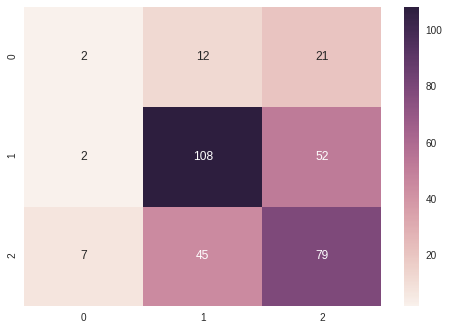

In [0]:
import seaborn as sns
from sklearn import metrics

y_pred = model.predict(x_test)
matrix = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
sns.heatmap(matrix,annot=True,fmt='.5g')

### Trainig From Scratch

In [0]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.summary()

optimizer = optimizers.Adam(lr=0.1)
loss = 'categorical_crossentropy'
epochs = 200
batch_size = 54

model.compile(optimizer= optimizer,
              loss = loss,
              metrics=['acc'])

history_6 = model.fit(x_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_4 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 99        
Total params: 1,320,131
Trainable params: 1,320,131
Non-trainable params: 0
_________________________________________________________________
Train on 1000 samples, validate on 316 samples
Epoch 1/200
1000/1000 [==============================] - 1s 947us/step - loss: 8.9635 - acc: 0.3990 - val_loss: 9.7933 - val_acc: 0.3924
Epoch 2/200
1000/1000 [==============================] - 0s 152us/step - loss: 9

#### Training From Scratch seems not a good idea

## Experiment 2 - Transfer Learning From IMDB - GLOVE

### 1. IMBD - Glove

####1. Load IMBD as Raw Text

In [0]:
with zipfile.ZipFile('drive/INFO7374_NeuralNetwork&AI/Assignment_3/aclImdb.zip','r') as zip_ref:
    zip_ref.extractall('')

In [0]:
import os

imdb_dir = 'aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [0]:
len(texts)

25000

####2. Tokenize Data

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100  # We will cut reviews after 100 words
training_samples = 10000  # We will be training on 200 samples
validation_samples = 200  # We will be validating on 10000 samples
max_words = 10000  # We will only consider the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Split the data into a training set and a validation set
# But first, shuffle the data, since we started from data
# where sample are ordered (all negative first, then all positive).
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train_mv = data[:training_samples]
y_train_mv = labels[:training_samples]
x_val_mv = data[training_samples: training_samples + validation_samples]
y_val_mv = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


####3. Download and Preprocess GloVe

In [0]:
embeddings_index = {}

with open('glove.6B.100d.txt') as f:
  for line in f:
      values = line.split()
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

####4. Train Model - Freeze Embedding Layer

In [0]:
from keras import optimizers
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_5 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


#### 5. Load the GloVe embeddings in the model

In [0]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

####6. Train and Evaluate - freeze embedding

In [0]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history_7 = model.fit(x_train_mv, y_train_mv,
                    epochs=100,
                    batch_size=32,
                    validation_data=(x_val_mv, y_val_mv))
model.save_weights('pre_trained_glove_model.h5')

base_model = model

Train on 10000 samples, validate on 200 samples
Epoch 1/100
10000/10000 [==============================] - 2s 228us/step - loss: 8.0015 - acc: 0.4981 - val_loss: 8.3698 - val_acc: 0.4750
Epoch 2/100
10000/10000 [==============================] - 2s 152us/step - loss: 8.0015 - acc: 0.4981 - val_loss: 8.3698 - val_acc: 0.4750
Epoch 3/100
10000/10000 [==============================] - 2s 151us/step - loss: 8.0015 - acc: 0.4981 - val_loss: 8.3698 - val_acc: 0.4750
Epoch 4/100
10000/10000 [==============================] - 2s 150us/step - loss: 8.0015 - acc: 0.4981 - val_loss: 8.3698 - val_acc: 0.4750
Epoch 5/100
10000/10000 [==============================] - 2s 159us/step - loss: 8.0015 - acc: 0.4981 - val_loss: 8.3698 - val_acc: 0.4750
Epoch 6/100
10000/10000 [==============================] - 2s 154us/step - loss: 8.0015 - acc: 0.4981 - val_loss: 8.3698 - val_acc: 0.4750
Epoch 7/100
10000/10000 [==============================] - 1s 147us/step - loss: 8.0015 - acc: 0.4981 - val_loss: 8.36

#### Build a model for Earnings Script Training Based on IMDB

In [0]:
base_model.load_weights('pre_trained_glove_model.h5')
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_5 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 33        
Total params: 1,320,065
Trainable params: 320,065
Non-trainable params: 1,000,000
_________________________________________________________________


In [0]:
model = Sequential()
for layer in base_model.layers[:-1]:
    model.add(layer)
    
for layer in model.layers:
  layer.trainable = False
  

model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_5 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_11 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 99        
Total params: 1,321,187
Trainable params: 1,155
Non-trainable params: 1,320,032
_________________________________________________________________


#### Train use Financial Data

In [0]:
optimizer = optimizers.Adam(lr=0.1)
loss = 'categorical_crossentropy'
epochs = 200
batch_size = 54

model.compile(optimizer= optimizer,
              loss = loss,
              metrics=['acc'])

history_7 = model.fit(x_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val))

Train on 1000 samples, validate on 316 samples
Epoch 1/200
1000/1000 [==============================] - 1s 977us/step - loss: 8.4017 - acc: 0.4760 - val_loss: 7.6510 - val_acc: 0.5253
Epoch 2/200
1000/1000 [==============================] - 0s 89us/step - loss: 7.9785 - acc: 0.5050 - val_loss: 7.6510 - val_acc: 0.5253
Epoch 3/200
1000/1000 [==============================] - 0s 94us/step - loss: 7.9785 - acc: 0.5050 - val_loss: 7.6510 - val_acc: 0.5253
Epoch 4/200
1000/1000 [==============================] - 0s 97us/step - loss: 7.9785 - acc: 0.5050 - val_loss: 7.6510 - val_acc: 0.5253
Epoch 5/200
1000/1000 [==============================] - 0s 89us/step - loss: 7.9785 - acc: 0.5050 - val_loss: 7.6510 - val_acc: 0.5253
Epoch 6/200
1000/1000 [==============================] - 0s 88us/step - loss: 7.9785 - acc: 0.5050 - val_loss: 7.6510 - val_acc: 0.5253
Epoch 7/200
1000/1000 [==============================] - 0s 103us/step - loss: 7.9785 - acc: 0.5050 - val_loss: 7.6510 - val_acc: 0.5253

####5. Training From Scratch

In [0]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

optimizer = optimizers.SGD(lr=0.01, nesterov=True)

model.compile(optimizer= optimizer,
              loss='binary_crossentropy',
              metrics=['acc'])
history_9 = model.fit(x_train_mv, y_train_mv,
                    epochs=200,
                    batch_size=32,
                    validation_data=(x_val_mv, y_val_mv))

base_model = model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_7 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 10000 samples, validate on 200 samples
Epoch 1/200
10000/10000 [==============================] - 3s 263us/step - loss: 0.6933 - acc: 0.5050 - val_loss: 0.6946 - val_acc: 0.4850
Epoch 2/200
10000/10000 [==============================] - 2s 184us/step - lo

In [0]:
model = Sequential()
for layer in base_model.layers[:-1]:
    model.add(layer)
    
for layer in model.layers:
  layer.trainable = False
  

model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_7 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_17 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_18 (Dense)             (None, 3)                 99        
Total params: 1,321,187
Trainable params: 1,155
Non-trainable params: 1,320,032
_________________________________________________________________


In [0]:
optimizer = optimizers.Adam(lr=0.1)
loss = 'categorical_crossentropy'
epochs = 200
batch_size = 54

model.compile(optimizer= optimizer,
              loss = loss,
              metrics=['acc'])

history_9 = model.fit(x_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val))

Train on 1000 samples, validate on 316 samples
Epoch 1/200
1000/1000 [==============================] - 1s 1ms/step - loss: 0.9698 - acc: 0.5020 - val_loss: 0.8941 - val_acc: 0.5190
Epoch 2/200
1000/1000 [==============================] - 0s 97us/step - loss: 0.8765 - acc: 0.5460 - val_loss: 0.8345 - val_acc: 0.6139
Epoch 3/200
1000/1000 [==============================] - 0s 92us/step - loss: 0.8342 - acc: 0.5900 - val_loss: 0.8110 - val_acc: 0.5949
Epoch 4/200
1000/1000 [==============================] - 0s 93us/step - loss: 0.8235 - acc: 0.6130 - val_loss: 0.8038 - val_acc: 0.6203
Epoch 5/200
1000/1000 [==============================] - 0s 99us/step - loss: 0.8271 - acc: 0.5990 - val_loss: 0.8235 - val_acc: 0.6108
Epoch 6/200
1000/1000 [==============================] - 0s 94us/step - loss: 0.8177 - acc: 0.6090 - val_loss: 0.8062 - val_acc: 0.5918
Epoch 7/200
1000/1000 [==============================] - 0s 91us/step - loss: 0.8250 - acc: 0.6030 - val_loss: 0.7980 - val_acc: 0.6076
Ep

In [0]:
optimizer = optimizers.Adam(lr=0.01)
loss = 'categorical_crossentropy'
epochs = 200
batch_size = 54

model.compile(optimizer= optimizer,
              loss = loss,
              metrics=['acc'])

history_9 = model.fit(x_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val))

Train on 1000 samples, validate on 316 samples
Epoch 1/200
1000/1000 [==============================] - 1s 1ms/step - loss: 0.7808 - acc: 0.6460 - val_loss: 0.8105 - val_acc: 0.6044
Epoch 2/200
1000/1000 [==============================] - 0s 143us/step - loss: 0.7788 - acc: 0.6540 - val_loss: 0.8131 - val_acc: 0.6076
Epoch 3/200
1000/1000 [==============================] - 0s 112us/step - loss: 0.7791 - acc: 0.6520 - val_loss: 0.8155 - val_acc: 0.6013
Epoch 4/200
1000/1000 [==============================] - 0s 132us/step - loss: 0.7785 - acc: 0.6550 - val_loss: 0.8104 - val_acc: 0.6108
Epoch 5/200
1000/1000 [==============================] - 0s 105us/step - loss: 0.7785 - acc: 0.6510 - val_loss: 0.8146 - val_acc: 0.6044
Epoch 6/200
1000/1000 [==============================] - 0s 104us/step - loss: 0.7793 - acc: 0.6530 - val_loss: 0.8099 - val_acc: 0.6139
Epoch 7/200
1000/1000 [==============================] - 0s 109us/step - loss: 0.7805 - acc: 0.6500 - val_loss: 0.8134 - val_acc: 0.6

In [0]:
optimizer = optimizers.SGD(lr=0.001)
loss = 'categorical_crossentropy'
epochs = 200
batch_size = 54

model.compile(optimizer= optimizer,
              loss = loss,
              metrics=['acc'])

history_9 = model.fit(x_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val))

Train on 1000 samples, validate on 316 samples
Epoch 1/200
1000/1000 [==============================] - 1s 1ms/step - loss: 0.7772 - acc: 0.6510 - val_loss: 0.8221 - val_acc: 0.5981
Epoch 2/200
1000/1000 [==============================] - 0s 102us/step - loss: 0.7772 - acc: 0.6510 - val_loss: 0.8220 - val_acc: 0.5981
Epoch 3/200
1000/1000 [==============================] - 0s 100us/step - loss: 0.7772 - acc: 0.6510 - val_loss: 0.8219 - val_acc: 0.5981
Epoch 4/200
1000/1000 [==============================] - 0s 98us/step - loss: 0.7771 - acc: 0.6510 - val_loss: 0.8218 - val_acc: 0.5981
Epoch 5/200
1000/1000 [==============================] - 0s 107us/step - loss: 0.7771 - acc: 0.6510 - val_loss: 0.8218 - val_acc: 0.5981
Epoch 6/200
1000/1000 [==============================] - 0s 95us/step - loss: 0.7771 - acc: 0.6520 - val_loss: 0.8217 - val_acc: 0.5981
Epoch 7/200
1000/1000 [==============================] - 0s 94us/step - loss: 0.7771 - acc: 0.6510 - val_loss: 0.8216 - val_acc: 0.5981

In [0]:
optimizer = optimizers.SGD(lr=0.01)
loss = 'categorical_crossentropy'
epochs = 200
batch_size = 54

model.compile(optimizer= optimizer,
              loss = loss,
              metrics=['acc'])

history_9 = model.fit(x_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val))

Train on 1000 samples, validate on 316 samples
Epoch 1/200
1000/1000 [==============================] - 1s 1ms/step - loss: 0.7762 - acc: 0.6500 - val_loss: 0.8178 - val_acc: 0.6044
Epoch 2/200
1000/1000 [==============================] - 0s 108us/step - loss: 0.7762 - acc: 0.6510 - val_loss: 0.8177 - val_acc: 0.6044
Epoch 3/200
1000/1000 [==============================] - 0s 110us/step - loss: 0.7762 - acc: 0.6510 - val_loss: 0.8177 - val_acc: 0.6044
Epoch 4/200
1000/1000 [==============================] - 0s 100us/step - loss: 0.7761 - acc: 0.6530 - val_loss: 0.8176 - val_acc: 0.6044
Epoch 5/200
1000/1000 [==============================] - 0s 102us/step - loss: 0.7761 - acc: 0.6520 - val_loss: 0.8175 - val_acc: 0.6044
Epoch 6/200
1000/1000 [==============================] - 0s 107us/step - loss: 0.7762 - acc: 0.6530 - val_loss: 0.8176 - val_acc: 0.6044
Epoch 7/200
1000/1000 [==============================] - 0s 101us/step - loss: 0.7761 - acc: 0.6530 - val_loss: 0.8175 - val_acc: 0.6

In [0]:
model.evaluate(x_test, y_test)

328/328 [==============================] - 0s 90us/step


[0.8900761676997673, 0.5670731707317073]

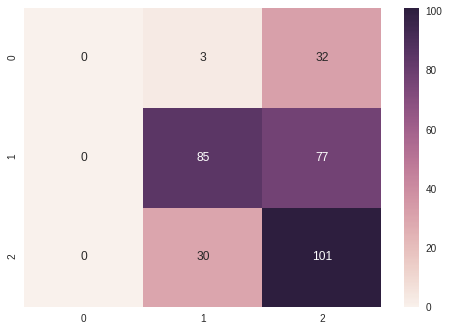

In [0]:
import seaborn as sns
from sklearn import metrics


y_pred = model.predict(x_test)
matrix = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
sns.heatmap(matrix,annot=True,fmt='.5g')

### 2.  IMBD - Keras Embedding

####1. Build Keras Embedding Layer

In [0]:
from keras.layers import Embedding

# The Embedding layer takes at least two arguments:
# the number of possible tokens, here 1000 (1 + maximum word index),
# and the dimensionality of the embeddings, here 64.
embedding_layer = Embedding(1000, 64)

####2. Load, Pad Data

In [0]:
from keras.datasets import imdb
from keras import preprocessing

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words 
# (among top max_features most common words)
maxlen = 20

# Load the data as lists of integers.
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# This turns our lists of integers
# into a 2D integer tensor of shape `(samples, maxlen)`
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

17465344/17464789 [==============================] - 0s 0us/step


#### 3. Build and Train Model

In [0]:
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()
# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs
model.add(Embedding(10000, 8, input_length=maxlen))
# After the Embedding layer, 
# our activations have shape `(samples, maxlen, 8)`.

# We flatten the 3D tensor of embeddings 
# into a 2D tensor of shape `(samples, maxlen * 8)`
model.add(Flatten())

# We add the classifier on top
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_8 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 4s 215us/step - loss: 0.6759 - acc: 0.6050 - val_loss: 0.6398 - val_acc: 0.6814
Epoch 2/10
20000/20000 [==============================] - 3s 152us/step - loss: 0.5657 - acc: 0.7427 - val_loss: 0.5467 - val_acc: 0.7206
Epoch 3/10
20000/20000 [==============================] - 3s 152us/step - los